In [1]:
# imports
from pyha_analyzer import extractors
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessorsNew
import torch
from datetime import datetime


import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader


from torchvision.utils import make_grid

from tqdm.notebook import tqdm

import numpy as np

In [2]:
config = {
    "learning_rate": 10e-3,
    "learning_rate_decay": 0.001,
    "device": 'cuda',
    "latent_dim": 10
}

In [3]:
# extract our data
coralreef_extractor = extractors.MultiCoralReef()
coral_ads = coralreef_extractor('/home/a.jajodia.229/acoustic/local_data/coral')


preprocessor = MelSpectrogramPreprocessorsNew(duration=5, class_list=coral_ads["train"].features["labels"].feature.names)

coral_ads["train"].set_transform(preprocessor)

min size is 15538 from dataset Paola
sampling 15538 from (Paola, 0)
sampling 15538 from (Paola, 1)
sampling 1294 from (Williams_et_al_2024, 0)
sampling 1294 from (Williams_et_al_2024, 1)
Loaded: 33664 samples


Casting the dataset:   0%|          | 0/23564 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3030 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7070 [00:00<?, ? examples/s]

In [4]:
# architecture from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0283396
encoder = lambda nfeat : torch.nn.Sequential(
    nn.Conv2d(1, 32, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.Conv2d(32, 64, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.Conv2d(64, 128, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.Conv2d(128, 256, 3, stride=2, bias=False, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.Conv2d(256, 1, 3, stride=2, padding=1),
    nn.Flatten(2),
    nn.Linear(64, nfeat)
)

decoder = lambda nfeat : torch.nn.Sequential(
    nn.Linear(nfeat, 64),
    nn.Unflatten(2, (8,8)),
    nn.ReLU(True),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(1, 256, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.Conv2d(256, 256, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv2d(256, 128, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.Conv2d(128, 128, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv2d(128, 64, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.Conv2d(64, 64, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv2d(64, 32, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.Conv2d(32, 32, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.Upsample(scale_factor=2),
    nn.Conv2d(32, 1, (3, 3), bias=False, padding=1),
    nn.BatchNorm2d(1),
    nn.ReLU(True),
    nn.Conv2d(1, 1, (3, 3), bias=False, padding=1)
)

In [5]:
encoder = encoder(config['latent_dim'])
decoder = decoder(config['latent_dim'])

model = nn.Sequential(
    encoder,
    decoder
).to(config['device'])

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0, lr=config["learning_rate"], betas=(0.8, 0.999))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (1-config["learning_rate_decay"])**epoch)
MSE = torch.nn.MSELoss()
train_loader = DataLoader(coral_ads['train'], batch_size=8, num_workers=8, shuffle=True, pin_memory=True, pin_memory_device=config['device'])

In [7]:
step, loss = 0, []

for epoch in range(1):
    for data in tqdm(train_loader, desc=str(epoch), leave=False):
        # prevtime = datetime.now()

        x = data['audio']
        
        optimizer.zero_grad()
        label = x.to(config["device"])[..., :256]
        
        x = encoder(label)
        
        pred = decoder(x)


        score = MSE(label, pred)
        score.backward()
        optimizer.step()
        
        loss.append(score.item())
        # print(datetime.now())

        if len(loss) > 2000 and np.median(loss[-2000:-1000]) < np.median(loss[-1000:]):
            print('Early stop')
            torch.save(model.state_dict(), "model.pt")
            exit()

        step += 1

        if step % 500 == 0: # scheduler
            scheduler.step()
            
            print(score)

        # # Plot images
        # if step % 100 == 0 :
        #     # Plot reconstructions
        #     images = [(e-e.min())/(e.max()-e.min()) for e in label[:8]]
        #     grid = make_grid(images)
            
            
        #     images = [(e-e.min())/(e.max()-e.min()) for e in pred[:8]]
        #     grid = make_grid(images)

0:   0%|          | 0/2946 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "dim_10.pt")

In [ ]:
model.load_state_dict(torch.load('dim_10.pt'))

<All keys matched successfully>

In [ ]:
coral_ads['test'].set_transform(preprocessor)
test_loader = DataLoader(coral_ads['test'], batch_size=8, num_workers=12, shuffle=True, pin_memory=True, pin_memory_device=config['device'])


test_losses = []

test_embeddings = []


for data in tqdm(test_loader):
    x = data['audio']
    with torch.no_grad():
        label = x.to(config["device"])[..., :256]
        
        x = encoder(label)
        
        print(x.shape)
        
        test_embeddings.append(x.detach().cpu())
        
        pred = decoder(x)


        score = MSE(label, pred)
    
        test_losses.append(score.item())
        
        break

  0%|          | 0/884 [00:00<?, ?it/s]

torch.Size([8, 1, 10])


In [ ]:
plotting_data = np.array(test_embeddings).squeeze().reshape(141*8, 2)

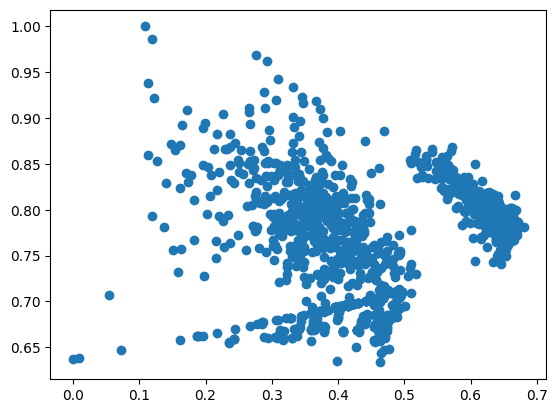

In [ ]:


plt.scatter(x=plotting_data[:,0], y=plotting_data[:,1])


In [ ]:
np.array(test_losses).mean()

np.float64(0.014642886817455292)

In [ ]:
normalize = lambda e: (e-e.min())/(e.max()-e.min())

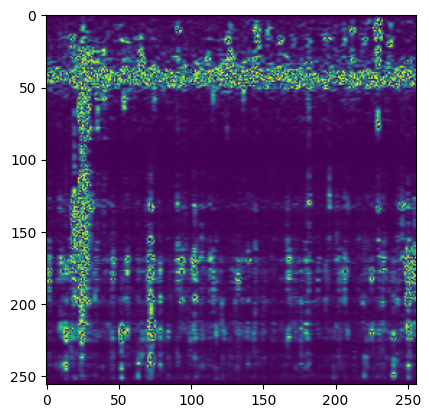

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(normalize(label[5]).detach().cpu().squeeze())

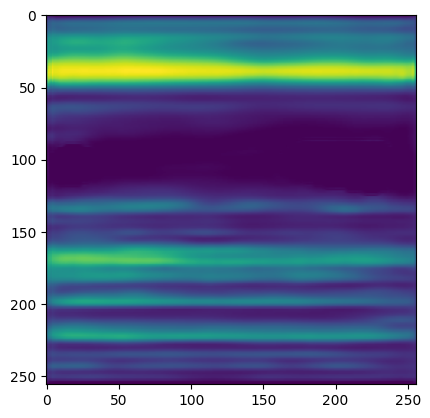

In [ ]:
plt.imshow(normalize(pred[5]).detach().cpu().squeeze())